# Energy A.I. Hackathon 2021 Workflow - Team Anticline
## Volumetric Calculations
#### Authors: Esmail Eltahan, Jeon Jonghyeon, Mehran Mehrabi, and Wen Pan, Hildebrand Department of Petroleum and Geosystems Engineering. 
#### The University of Texas at Austin, Austin, Texas USA 

<img src="anticline_official_logo.png" width=300 />



## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load the data

In [3]:
train_static_well_dat=pd.read_csv('wellbore_data_preproduction_well.csv')
test_static_well_dat=pd.read_csv('wellbore_data_producer_wells.csv')
ai = np.load("2d_ai.npy")
sand_propotion = np.load("2d_sand_propotion.npy")
sandy_shale_propotion = np.load("2d_sandy_shale_propotion.npy")
shale_propotion = np.load("2d_shale_propotion.npy")
shaly_sand_propotion = np.load("2d_shaly_sand_propotion.npy")
top_depth = np.load("2d_top_depth.npy")
df_production = pd.read_csv('production_history.csv')


## Make calculations

In [4]:
df_production.columns = ['Well_ID','Cumoil1', 'Cumoil2', 'Cumoil3', 'Cumwater1', 'Cumwater2', 'Cumwater3']
static_well_dat=pd.concat([train_static_well_dat,test_static_well_dat])
static_well_dat.rename(columns = {'X, m':'X', 'Y, m': 'Y', 'Depth, m':'Depth','Porosity, fraction':'Porosity', 'Rock facies': 'Facies','Density, g/cm3': 'Density','Acoustic Impedance, kg/s-m^2': 'AI','Permeability, mD': 'Perm'}, inplace = True)
# add layer as a feature
static_well_dat['layer']=np.arange(static_well_dat.shape[0])%20
litho_keys = {'Shale':0,
                     'Sandy shale':1,
                     'Shaly sandstone': 2,
                     'Sandstone': 3}
static_well_dat['lith_id'] = static_well_dat['Facies'].map(litho_keys)
static_well_dat.tail(40)
N=np.unique(static_well_dat['Well_ID']).size
N_features=static_well_dat.shape[-1]
static_well_dat_per_well=(static_well_dat.values).reshape([N,-1,N_features])

## Load simulated maps

Now we load the already simulated maps per facies that we obtained using sequential Gaussian simulations. The porosity and permeability maps are merged into two large array `por_maps` and `perm_maps`. Each of the arrays has dimension $(L, N, N)$ where $L$ is the number of realizations, $N$ is the number of cells in $x$ and $y$ directions. 

In [5]:
perm_maps = []
por_maps = []
for i in range(N):
    perm_maps.append(np.load("./sgs_maps/perm_{0:03d}.npy".format(i)))
    por_maps.append(np.load("./sgs_maps/por_{0:03d}.npy".format(i)))
por_maps = np.array(por_maps)
perm_maps = np.array(por_maps)

## Define reservoir properties

Now, we define reservoir properties and make assumtions. Given properies are the water oil contact 
`woc` = 3067.4 m, connate water saturation `Swc` = 20.3%. We have the simulated maps for porosity and the given map for the top depth of the formation. We have all what we need to provide a volumetric estimate for the initial oil in place `IOIP`, except for the formation volume factor `Bo`, which we assume to be = 1.4 STB/RB.

In [15]:
woc = 3067.4
Swc = 20.3/100
dx = 50
dy = 50
Bo = 1.4
N = 100

top_depth=top_depth.reshape([1,200,200])

## Estimate initial oil in place

We estimate the initial oil in place using the volumetric equation:

$$IOIP = \frac{6.289}{1000 B_o} \int\int\phi(x,y) (WOC - d_{top}(x,y)) (1-S_{wc})\,dx\,dy$$

where the fraction $\frac{6.289}{1000 B_o}$ is to convert the volume from reservoir conditions ($m^3$) to surface conditions (thousand stock tank barrels, MSTB)

In [16]:
IOIPs = np.zeros(N)
#numerical integration
IOIPs = np.sum((1 / Bo) * por_maps * (woc - top_depth) * (1 - Swc) * dx * dy * 6.28981/ 1000, axis =(1,2))  # in MSTB
thickness = woc-top_depth
thickness.mean()
print("Mean IOIP = {:.2f} MSTB".format(IOIPs.mean()))
print("Std. IOIP = {:.2f} MSTB".format(IOIPs.std()))

Mean IOIP = 618834.78 MSTB
Std. IOIP = 1348.32 MSTB


## Estimate recovery factor

We estimate the recovery factor at the end of year 1, 2, and 3. 

$$RF = \frac{G_p}{IOIP}$$

where $G_p$ is the field cumulative oil production. 

In [17]:
Gp_1 = np.sum(df_production['Cumoil1'].values)
Gp_2 = np.sum(df_production['Cumoil2'].values)
Gp_3 = np.sum(df_production['Cumoil3'].values)
IOIP_0 = IOIPs[0]
rf1 = 1 - (IOIPs - Gp_1) / IOIPs
rf2 = 1 - (IOIPs - Gp_2) / IOIPs
rf3 = 1 - (IOIPs - Gp_3) / IOIPs
print("Oil RF 1st year mean = {:.2f} %, std = {:.2f} %".format(rf1.mean()*100, rf1.std()*100))
print("Oil RF 2nd year mean = {:.2f} %, std = {:.2f} %".format(rf2.mean()*100, rf2.std()*100))
print("Oil RF 3rd year mean = {:.2f} %, std = {:.2f} %".format(rf3.mean()*100, rf3.std()*100))

Oil RF 1st year mean = 5.73 %, std = 0.01 %
Oil RF 2nd year mean = 8.89 %, std = 0.02 %
Oil RF 3rd year mean = 11.10 %, std = 0.02 %


## Estimate rise in WOC

The reservoir under study shows evidence of strong water drive. We believe that the produced oil will be replaced by water from the bottom aquifer. That will cause the water-oil contact (WOC) to rise as the reservoir undergoes depletion. If we assume that no expansion of water, nor expansion of oil, we can write a mass balance in order to determine the the rise of WOC every year, on average, assuming uniform rise accross the reservoir

$$\Delta h_w  = \frac{\frac{1000}{6.289} G_p\times B_o}{\,\int\int\phi(x,y)(1-S_{wc})\,dx\,dy}$$

where $G_p$ is the field cumulative oil production. 

In [18]:
delta_h1 =  Gp_1 * 1000 / np.sum((1 / Bo) * por_maps * (1 - Swc) * dx * dy * 6.28981, axis =(1,2)) 
delta_h2 =  Gp_2 * 1000 / np.sum((1 / Bo) * por_maps * (1 - Swc) * dx * dy * 6.28981, axis =(1,2)) 
delta_h3 =  Gp_3 * 1000 / np.sum((1 / Bo) * por_maps * (1 - Swc) * dx * dy * 6.28981, axis =(1,2)) 
print("Average Rise in WOC 1st year = {:.3f} m, std = {:.3f} m".format(delta_h1.mean(), delta_h1.std()))
print("Average Rise in WOC 2nd year = {:.3f} m, std = {:.3f} m".format(delta_h2.mean(), delta_h2.std()))
print("Average Rise in WOC 3rd year = {:.3f} m, std = {:.3f} m".format(delta_h3.mean(), delta_h3.std()))
print("Average thickness of reservoir = {:.3f} m".format(thickness.mean()))

Average Rise in WOC 1st year = 0.840 m, std = 0.002 m
Average Rise in WOC 2nd year = 1.302 m, std = 0.003 m
Average Rise in WOC 3rd year = 1.626 m, std = 0.004 m
Average thickness of reservoir = 14.492 m


We can do a better job than assuming the rise is uniform accross the reservoir. The rise in WOC should be higher at regions of high oil production, (or equivalently high depletion). We could scale the values we get by the pressure maps we previously obtained. Those pressure maps are directly correlated to the total field production from adjacent wells, and hence it could be used as indicator for the rise in WOC also. 

In [9]:
dp_1 = np.load("./engineered_maps/dp_1.npy")
dp_2 = np.load("./engineered_maps/dp_2.npy")
dp_3 = np.load("./engineered_maps/dp_3.npy")

In [10]:
woc_rise_1 = dp_1 * delta_h1.mean() /dp_1.mean() 
woc_rise_2 = dp_2 * delta_h2.mean() /dp_2.mean() 
woc_rise_3 = dp_3 * delta_h3.mean() /dp_3.mean() 

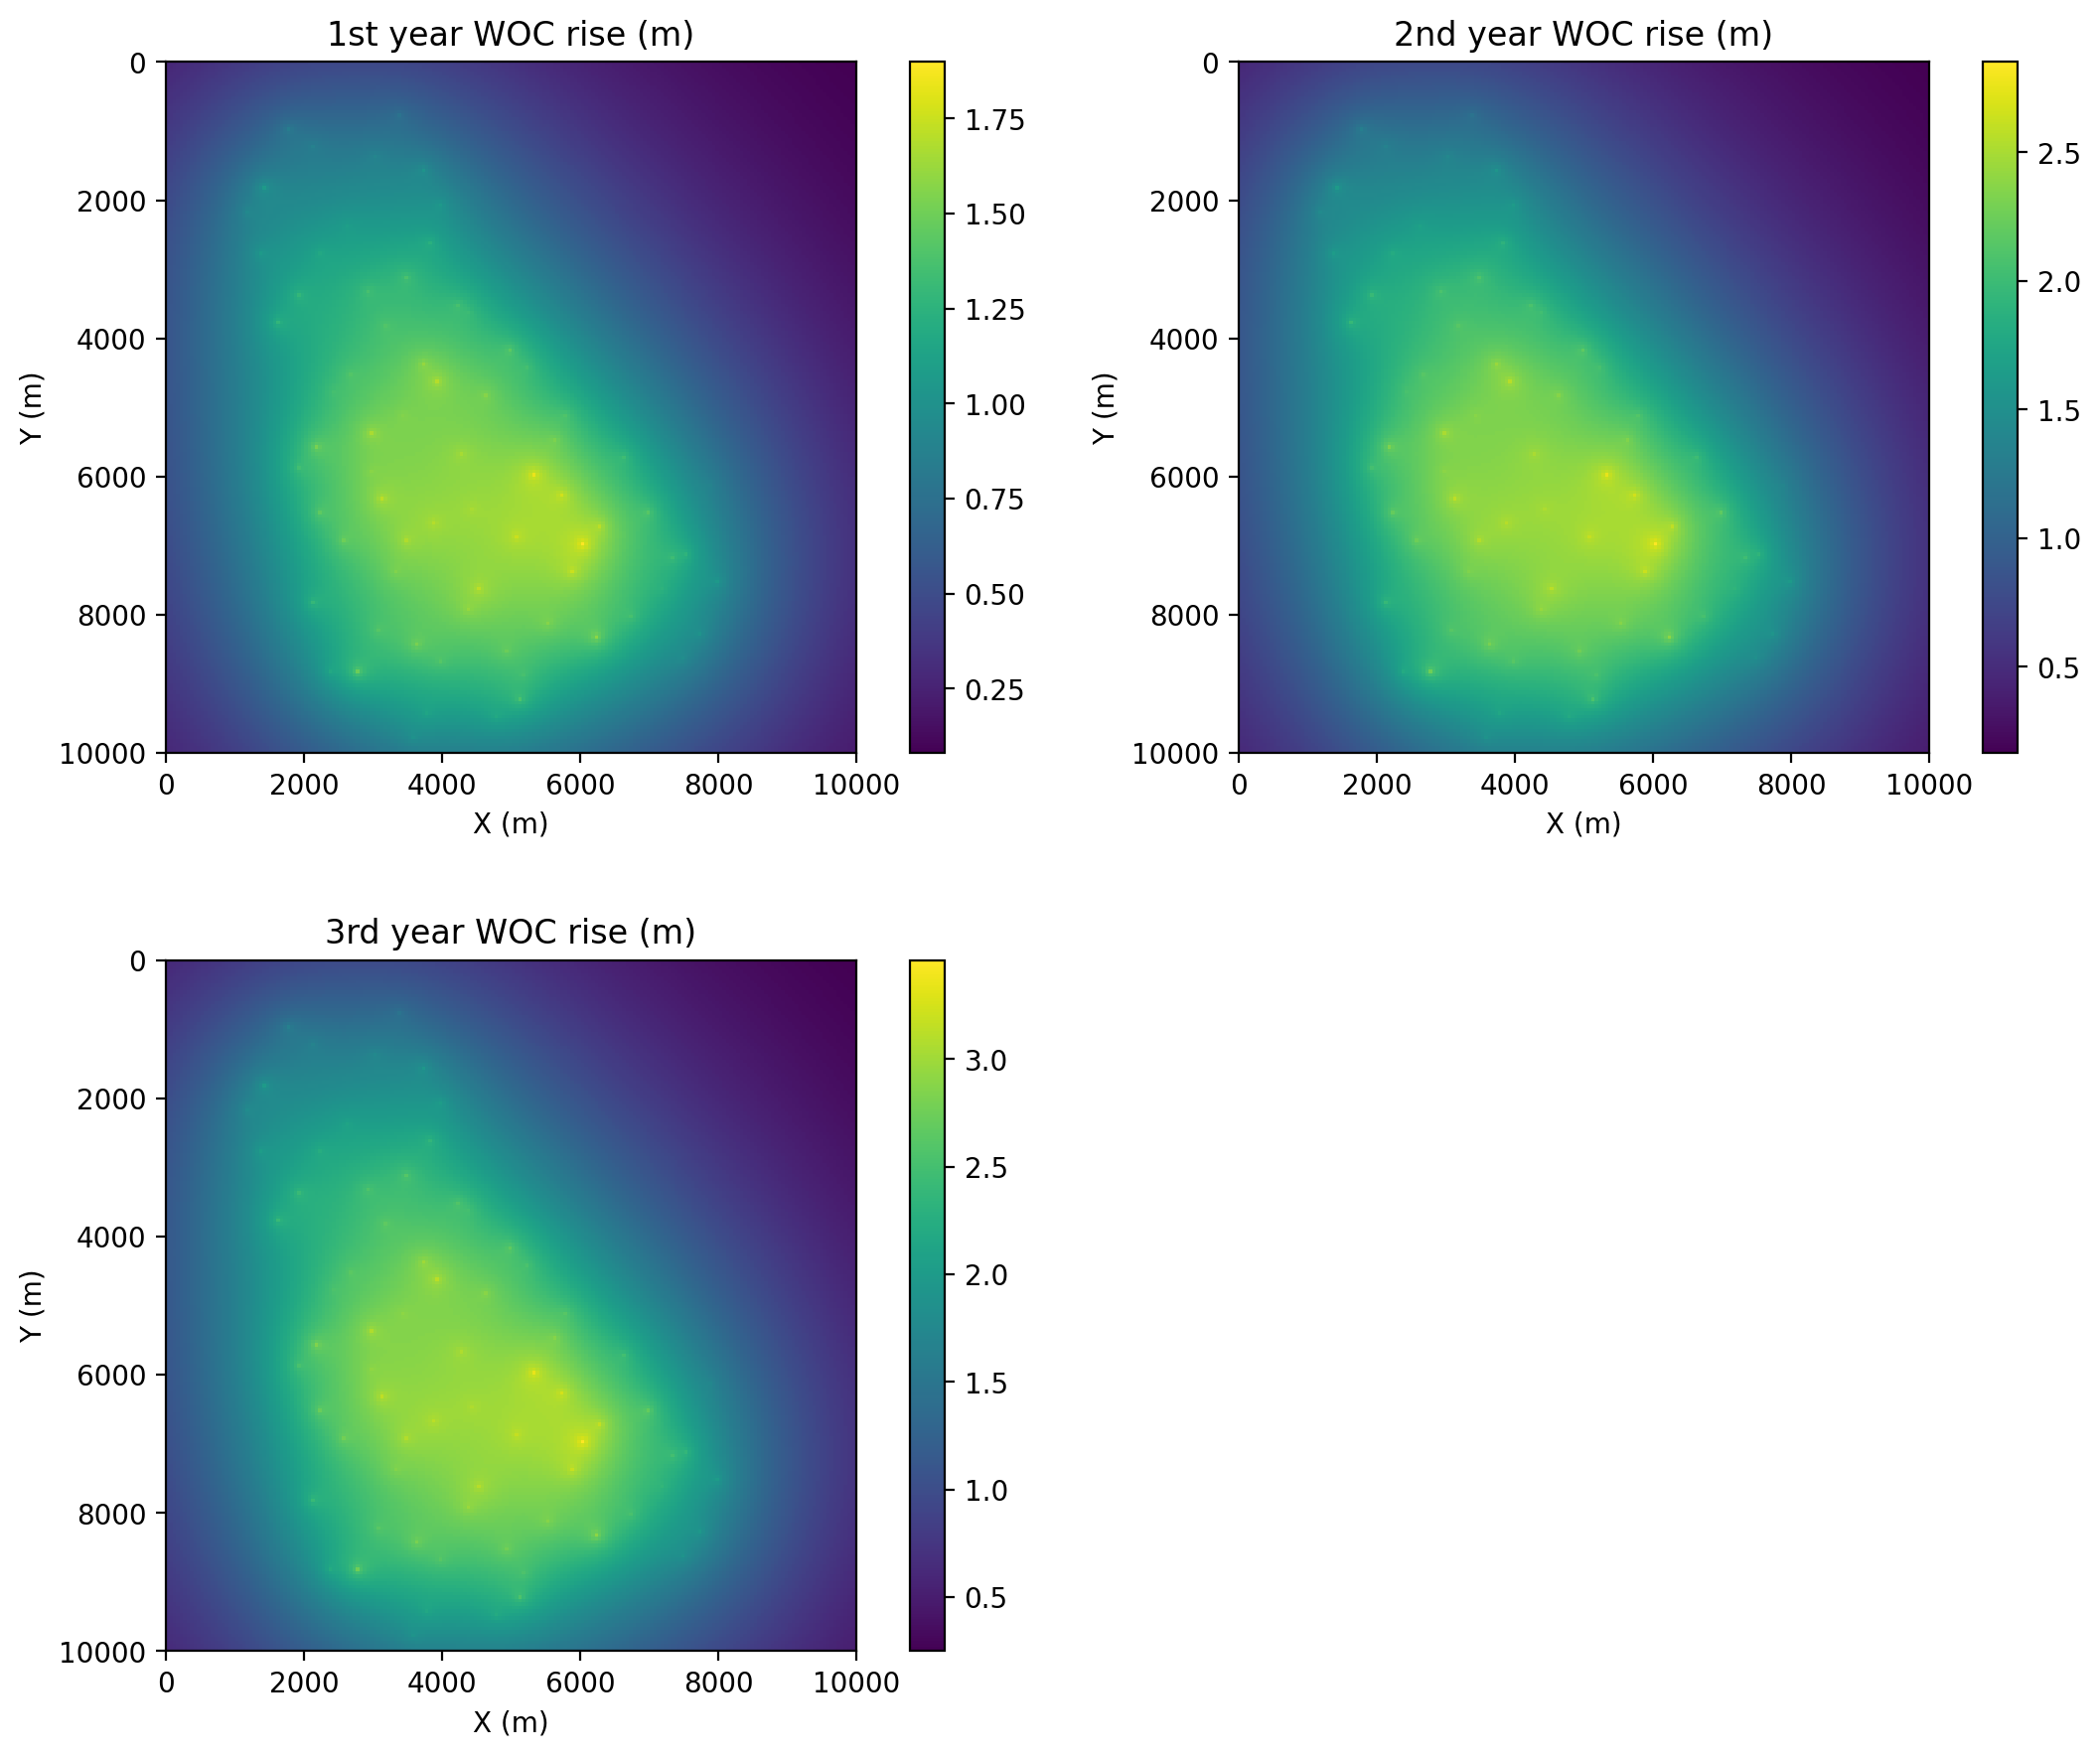

In [11]:
x = np.linspace(0,10000, 50)
y= np.linspace(0,10000, 50)

plt.figure(dpi=200)
plt.subplot(221)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("1st year WOC rise (m)")
plt.imshow(woc_rise_1, extent=(x.min(), x.max(), y.max(), y.min()))
plt.colorbar()
plt.gca().invert_yaxis()
plt.subplot(222)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("2nd year WOC rise (m)")
plt.imshow(woc_rise_2, extent=(x.min(), x.max(), y.max(), y.min()))
plt.colorbar()
plt.gca().invert_yaxis()
plt.subplot(223)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("3rd year WOC rise (m)")
plt.imshow(woc_rise_3, extent=(x.min(), x.max(), y.max(), y.min()))
plt.colorbar()
plt.gca().invert_yaxis()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=2, wspace=0., hspace =0.3)

plt.show()

In [12]:
np.save("./engineered_maps/woc_rise_1",woc_rise_1)
np.save("./engineered_maps/woc_rise_2", woc_rise_2)
np.save("./engineered_maps/woc_rise_3", woc_rise_3)